# 5.1 Least Squares Global Localization

Least Squares Positioning is a well-known algorithm for estimating the robot localization $x$ given a set of known landmarks in a map. Least Squares is akin to find the best pose $\hat{x}$ by solving a system of equations of the form:

$$z_{m \times 1} = H_{m \times n} \cdot x_{n \times 1}$$

where: 
- $n$ is the length of the pose ($n=3$ in our case, position plus orientation),
- $m$ represents the number of observations, and 
- $H$ is the matrix that codifies the observation model relating the measurement $z$ with the robot pose $x$. 

This simple concept, nevertheless, has to be modified in order to be used  in real scenarios:

## 5.1.1 Pseudo-inverse

Generally, to solve an equation system, we only need as many equations as variables. In the robot localization problem, each observation $z$ sets an equation, while the variables are the components of the state/pose, $x$. 

In such a case, where $n=m$, a direct attempt to this problem exists:

  $$x = H ^{-1} z$$

So a unique solution exists if $H$ is invertible, that is, $H$ is a square matrix with $det(H) \neq 0$. 

However, in real scenarios typically there are available more observations than variables. An approach to address this could be to drop some of the additional equations, but given that observations $z$ are inaccurate (they have been affected by some noise), we may use the additional information to try to mitigate such noise. However, by doing that $H$ is no a squared matrix anymore, hence not being invertible. 

Two tools can help us at this point. The first one is the utilization of **Least Squares** to find the closest possible $\hat{x}$, i.e. the one where the the error ($e = Hx -z$) is minimal:

  $$ \hat x = \arg\min_{x} e^Te = [(z-Hx)^T(z-Hx)] = \arg\min_x || z-Hx ||^2$$

which has a close form solution using the **pseudo-inverse** of a matrix:
  
  $$\hat{x} = \underbrace{(H^T H)^{-1} H^T}_{\textit{pseudo-inverse }(H^+)} z$$

The **pseudo-inverse**, in contrast to the normal inverse operation, can be used in non-square matrices!  

In [ ]:
#%matplotlib notebook
#%matplotlib inline

# IMPORTS

import math

import numpy as np
from numpy import linalg
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import scipy
from scipy import stats

import sys
sys.path.append("..")
from utils.PlotEllipse import PlotEllipse
from utils.DrawRobot import DrawRobot
from utils.tcomp import tcomp
from utils.tinv import tinv, jac_tinv1 as jac_tinv
from utils.Jacobians import J1, J2

### **<span style="color:green"><b><i>ASSIGNMENT 1: Playing with a robot in a corridor</i></b></span>** 

The following code illustrates a simple scenario where a robot is in a corridor looking at a door, which is placed at the origin of the reference system (see Fig.1). The robot is equipped with a laser scanner able to measure distances, and takes a number of observations $z$. The robot is placed 3 meters away from the door, but this information is unknown for it. **Your goal is** to estimate the position of the robot in this 1D world using such measurements. $\\[5pt]$

<figure style="text-align:center">
  <img src="images/corridor.png" alt="">
  <figcaption>Fig. 1: Simple 1D scenario with a robot equipped with a laser scanner measuring distance to a door.</figcaption>
</figure>

The following code cell shows the dimensions of all the actors involved in LS-positioning. Complete it for computing the robot pose $x$ from the available information. *Recall [`np.linalg.inv()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html).* 

In [2]:
# Set the robot pose to unknown
x = np.vstack(np.array([None]))

# Sensor measurements to the door
z = np.vstack(np.array([3.7,2.9,3.6,2.5,3.5]))

# Observation model
H = np.ones(np.array([5,1]))

print ("Dimensions:")
print ("Pose x:         " + str(x.shape))
print ("Observations z: " + str(z.shape))
print ("Obs. model H:   " + str(H.shape))
print ("H.T@H:          " + str((H.T@H).shape))
print ("inv(H.T@H):     " + str((np.linalg.inv(H.T@H)).shape))
print ("H.T@z :         " + str((H.T@z).shape))

# Do Least Squares Positioning
x = np.linalg.inv(H.T@H)@H.T@z

print('\nLS-Positioning')
print('x = ' + str(x[0]))

Dimensions:
Pose x:         (1, 1)
Observations z: (5, 1)
Obs. model H:   (5, 1)
H.T@H:          (1, 1)
inv(H.T@H):     (1, 1)
H.T@z :         (1, 1)

LS-Positioning
x = [3.24]


<span style="color:blue">Expected output</span>

```
x = [3.24]
```

## 5.1.2 Weighted measurements

In cases where multiple sensors affected by different noise profiles are used, or in those where the robot is using a sensor with a varying error (*e.g.* typically radial laser scans are more accurate while measuring distances to close objects), it is interesting to weight the contribution of such measurements while retrieving the robot pose. For example, we are going to consider a sensor whose accuracy drops the further the observed landmark is. Given a *covariance* matrix $Q$ describing the error in the measurements, the equations above are rewritten as:

  $$ \hat x = \arg\min_{x} e^T Q^{-1} e = [(Hx-z)^TQ^{-1}(Hx-z)] $$

  $$
    \begin{aligned}
      &\hat{x} \leftarrow (H^T Q^{-1} H)^{-1} H^T Q^{-1} z &\text{(1. Best estimation)}\\ 
      &\Sigma_{\hat{x}} \leftarrow (H^T Q^{-1} H)^{-1} &\text{(2. Uncertainty of the estimation)}\\
    \end{aligned}
  $$
  
  Example with three measurements having different uncertainty ($\sigma_1^2$, $\sigma_2^2$, $\sigma_3^2$):
  
  $$
  e^T Q^{-1} e = [e_1 \; e_2 \; e_3]
  \begin{bmatrix} 1 / \sigma_1^2 & 0 & 0 \\ 0 & 1/\sigma_2^2 & 0 \\ 0 & 0 & 1/\sigma_3^2 \end{bmatrix} 
  \begin{bmatrix} e_1 \\ e_2 \\ e_3 \end{bmatrix}
  = \frac{e_1^2}{\sigma_1^2} + \frac{e_2^2}{\sigma_2^2} + \frac{e_3^2}{\sigma_3^2}
  = \sum_{i=1}^m \frac{e_i^2}{\sigma_i^2}
  $$
  
  In this way, the bigger the $\sigma_i^2$, the smaller its contribution to the pose's computation.
  
  

### **<span style="color:green"><b><i>ASSIGNMENT 2: Adding growing uncertainty</i></b></span>** 

We have new information! The manufacturer of the laser scanner mounted on the robot wrote an email telling us that the device is considerably more inaccurate for further distances. Concretely, such uncertainty is characterized by $\sigma^2=e^z$ (the laser is not so accurate, being polite).

With this new information, implement the computation of the weighted LS-positioning so you can compare the previously estimated position with the new one.

In [3]:
# Sensor measurements to the door
z = np.vstack(np.array([3.7,2.9,3.6,2.5,3.5]))

# Uncertainty of the measurements
Q = np.eye(5)*np.exp(z)

# Observation model
H = np.ones(np.array([5,1]))

# Do Least Squares Positioning
x = np.linalg.inv(H.T@H)@H.T@z

# Do Weighted Least Squares Positioning
x_w = np.linalg.inv((H.T@np.linalg.inv(Q)@H))@H.T@np.linalg.inv(Q)@z

print('\nLS-Positioning')
print('x = ' + str(x[0]))

print('\nWeighted-LS-Positioning')
print('x = ' + str(np.round(x_w[0],2)))


LS-Positioning
x = [3.24]

Weighted-LS-Positioning
x = [3.01]


<span style="color:blue">Expected output</span>

```
LS-Positioning
x = [3.24]

Weighted-LS-Positioning
x = [3.01]
```

## 5.1.3 Non-linear Least Squares

Until now we have assumed that $\hat{x}$ can be solved as a simple system of equations, i.e. $H$ is a matrix. Nevertheless, typically observation models are non-linear, that is: $z = h(x)$, so the problem now becomes:

  $$
  \hat x = \arg\min_x ||z-h(x)||^2
  $$
  
  No close-form solutions exists for this new problem, but we can approximate it iteratively:
  
  $$ 
  \textit{(Recall) Taylor expansion: } h(x) = h(x_0+\delta) = h(x_0) + J_{h_0}\delta \\
  ||z-h(x)||^2 \cong ||\underbrace{z-h(x_0)}_{\textit{error vector $e$}}-J_{h_o}\delta||^2 = ||e-J_{h_0}\delta||^2 \leftarrow \textit{$\delta$ is unknown, $J_e=-J_{h_0}$}$$
  
So we can define the equivalent optimization problem:
  
$$
  \delta = \arg\min_\delta ||e + J_e \delta||^2 \rightarrow \underbrace{\delta}_{nx1} = -\underbrace{(J_e^T J_e)^{-1}}_{nxn}\underbrace{J_e^T}_{nxm} \underbrace{e}_{mx1} \textit{ ($\delta$ that makes the previous squared norm minimum)}
  $$
  
  The weighted form of the $\delta$ computation results:
  
  $$
  \delta = (J_e^T Q^{-1} J_e)^{-1}J_e^T Q^{-1} e
  $$
  
Where:
  
  - $Q$ is the measurement covariance (*weighted measurement*)
  - $J_e$ is the negative of the Jacobian of the observation model at $\hat{x}$, also known as $\nabla h_{\hat{x}}$
  - $e$ is the error of $z$ against $h(\hat{x})$ (computed using the map information).
  
As commented, there is no closed-form solution for the problem, but we can iteratively approximate it using the **Gauss-Newton algorithm**:

  $$
  \begin{aligned}
      &\hat{x} \leftarrow (\dots)  &\text{(1. Initial guess)} \\
      &\delta \leftarrow (J_e^T Q^{-1} J_e)^{-1} J_e^T  Q^{-1} e  &\text{(2. Evaluate delta/increment)} \\
      &\hat{x} \leftarrow \hat{x} - \delta &\text{(3. Update estimation)} \\
      &\textit{if }\delta > \textit{tolerance} \rightarrow \textit{goto (1.)} \\
      &\textit{else } \rightarrow \textit{return }\hat{x} &\text{(4. Exit condition)}\\
  \end{aligned}
  $$
  

  

### LS positioning in practice

Suppose that a mobile robot equipped with a range sensor aims to localize itself in a map consisting of a number of landmarks by means of Least Squares and Gauss-Newton optimization.

For that, **you are provided with** the class `Robot` that implements the behavior of a robot that thinks that is placed at `pose` (that's its initial guess, obtained by composing odometry commands), but that has a real position `true pose`. In addition, the variable `cov` models the uncertainty of its movement, and `var_d` represents the variance (noise) of the range measurements. Take a look at it below.


In [4]:
class Robot(object):
    """ Simulate a robot base and positioning.
    
        Attrs:
            pose: Position given by odometry (in this case true_pose affected by noise)
            true_pose: True position, selected by the mouse in this demo
            cov: Covariance for the odometry sensor. Used to add noise to pose
            var_d: Covariance (noise) of each range measurement
    """
    def __init__(self,
                 pose: np.ndarray,
                 cov: np.ndarray,
                 desv_d: int = 0):
        # Pose related        
        self.true_pose = pose
        self.pose = pose + np.sqrt(cov)@scipy.randn(3, 1)
        self.cov = cov
        
        # Sensor related
        self.var_d = desv_d**2
    
    def plot(self, fig, ax, **kwargs):
        DrawRobot(fig, ax, self.pose, color='red', label="Pose estimation (Odometry)", **kwargs)
        DrawRobot(fig, ax, self.true_pose, color="blue", label="Real pose", **kwargs)

### **<span style="color:green"><b><i>ASSIGNMENT 3a: Computing distances from the robot to the landmarks</i></b></span>** 

**Implement the following function** to simulate how our robot observes the world. In this case, the landmarks in the map act as beacons: the robot can sense how far away they are without any information about angles. The robot uses a range sensor with the following observation model:

  $$
  z_i=[d_i]=h(m_i,x)=\left[\sqrt{(x_i-x)^2+(y_i-y)^2} \; \right]+w_i
  $$ 

  where $m_i$ stands for the $i^{th}$ landmark, and $w_i$ is a noise added by the sensor.

  Consider two scenarios in the function implementation:
  - The measurment is carried out with an ideal sensor, so no noise nor uncertainty exists (`cov_d = 0`).
  - The measurement comes from a real sensor affected by a given noise (`cov_d != 0`). We are going to consider that the range sensor is more accurate measuring distances to close landmarks than to far away ones. To implement this, consider that the noise grows with the root of the distance to the landmark, so the resultant uncertainty can be retrieved by: $\\[5pt]$
$$
 \sigma_{\text{dist}} = \sigma\sqrt{z}\\[5pt]
$$ 
that is, `np.sqrt(z)*np.sqrt(cov_d)`. Recall that the sensor noise is modeled as a gaussian distribution, so you have to define such distribution and take samples from it  using the [`stats.norm()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) and [`rvs()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.rvs.html) functions.

In [5]:
def distance(pose: np.ndarray, m: np.ndarray, cov_d: int = 0) -> np.ndarray:
    """ Get observations for every landmark in the map.

    In this case our observations are range only.
    If cov_d > 0 then add gaussian noise with var_d covariance

    Args:
        pose: pose (true or noisy) of the robot taking observation
        m: Map containing all landmarks
        cov_d: Covariance of the sensor

    Returns
        z: numpy array containing distances to all obs. It has shape (nLandmars, 1). 
    """
    z = np.sqrt((m[0]-pose[0])**2 + (m[1]-pose[1])**2)
    # compute distances to all landmarks
        

    if cov_d > 0:
        z += np.sqrt(z)*np.sqrt(cov_d) # add noise if needed

    return z

**Try your brand new function** with the following code:

In [6]:
# Define the robot pose, a map composed of 3 landmarks, and the sensor variance (we are using an ideal sensor)
pose = np.vstack([2, 2, 0.35])
m = np.array([[-5,-15],[20,56],[54,-18]]).T
cov_d = 0

# Compute distances from the sensor to the landmarks
z = distance(pose,m,cov_d)

# Now consider a noisy sensor
cov_d = 0.5
np.random.seed(seed=0)
z_with_noise = distance(pose,m,cov_d)

# Show the results
print('Measurements without noise:' + str(z))
print('Measurements with noise:   ' + str(z_with_noise))

Measurements without noise:[18.38477631 56.92099788 55.71355311]
Measurements with noise:   [21.41667145 62.25583611 60.99150504]


<span style="color:blue">Expected output</span>

```
Measurements without noise:[18.38477631 56.92099788 55.71355311]
Measurements with noise:   [23.73319805 59.05577186 60.87928514]
```

### **<span style="color:green"><b><i>ASSIGNMENT 3b: Implementing the algorithm</i></b></span>** 

Finally, we get to implement the Least Squares algorithm for localization. We ask you to complete the gaps in the following function, which:
  - Starts by initializing the Jacobian of the observation function (`Jh`) and takes as initial guess (`xEst`) the position at which the robot thinks it is as given by its odometry (`R1.pose`).
  - Then, it enters into a loop until convergence is reached, where:
    1. The distances `zEst` to each landmark from the estimated position `xEst`are computed. Recall that the map (landmarks positions) are known (`w_map`).
    - The error is computed by substracting to the obsevations provided by the sensor `z` the distances `zEst` computed at the previous point. Then, the residual error is computed as $e_{residual}=\sqrt{e_x^2+e_y^2}$.
    - The Jacobian of the observation model is evaluated at the estimated robot pose (`xEst`). This Jacobian has two columns and as many rows as observations to the landmarks: $\\[10pt]$
    $$
    jH = 
    \begin{bmatrix} 
        \frac{-1}{d_1}(x_1-x) & \frac{-1}{d_1}(y_1-y) \\
        \frac{-1}{d_2}(x_2-x) & \frac{-1}{d_2}(y_2-y) \\
        \cdots & \cdots \\
        \frac{-1}{d_n}(x_n-x) & \frac{-1}{d_n}(y_n-y) \\ 
    \end{bmatrix}
    $$    
being $xEst=[x,y]$, $[x_i,y_i]$ the position of the $i^{th}$ landmark in the map, and $d$ the distance previously computed from the robot estimated pose $xEst$ to the landmarks. The jacobian of the error `jE`is just `-jH`.
    - Computes the increment $\delta$ (`incr`) and substract it to the estimated pose (`xEst`). *Note: recall that $\delta = (J_e^T Q^{-1} J_e)^{-1}J_e^T Q^{-1} e$*

In [87]:
def LeastSquaresLocalization(R1: Robot,
                             w_map: np.ndarray,
                             z: np.ndarray,
                             nIterations=10,
                             tolerance=0.001,
                             delay=0.5) -> np.ndarray:
    """ Pose estimation using Gauss-Newton for least squares optimization
    
        Args:
            R1: Robot which pose we must estimate
            w_map: Map of the environment
            z: Observation received from sensor
            
            nIterations: sets the maximum number of iterations (default 10)
            tolerance: Minimum error difference needed for stopping the loop (convergence) (default 0.001)
            
            delay: Wait time used to visualize the different iterations (default 0.5)
            
        Returns:
            xEst: Estimated pose
    
    """
    
    iteration = 0
    
    # Initialization of useful variables
    incr = np.ones((2, 1)) # Delta
    jH = np.zeros((w_map.shape[1], 2)) # Jacobian of the observation function of all the landmarks
    xEst = R1.pose #Initial estimation is the odometry position (usually noisy)
    
    # Let's go!
    while linalg.norm(incr) > tolerance and iteration < nIterations:
        #if plotting:
        plt.plot(xEst[0], xEst[1], '+r', markersize=1+math.floor((iteration*15)/nIterations))
        # Compute the predicted observation (from xEst) and their respective Jacobians

        # 1) TODO: Compute distance to each landmark from xEst (estimated observations w/o noise)
        # 
        zEst = distance(xEst, w_map, cov_d=0)
        
        # 2) TODO: error = difference between real observations and predticed ones.
        e = z - zEst
        residual = np.sqrt(e.T@e) #residual error = sqrt(x^2+y^2)

        # 3) TODO: Compute Jacobians with respect (x,y) (slide 13)
        # The jH is evaluated at our current guest (xEst) -> z_p
        
        for i in range(0, zEst.size):
            for j in range(0, 2):
                jH[i, j] = (-1/zEst[i])*(w_map[j, i] - xEst[j, 0])
        
        jE = -jH

        # The observation variances Q grow with the root of the distance
        Q = np.diag(R1.var_d*np.sqrt(z))

        # 4) TODO: Solve the equation --> compute incr
        incr = (np.linalg.inv(jE.T@(np.linalg.inv(Q))@jE))@jE.T@(np.linalg.inv(Q))@e
        
        plt.plot([xEst[0, 0], xEst[0, 0]-incr[0]], [xEst[1, 0], xEst[1, 0]-incr[1]], 'r')
        xEst[0:2, 0] -= incr

        print ("Iteration :" + str(iteration))
        print ("  delta :   " + str(incr))
        print ("  residual: " + str(residual))
        
        iteration += 1
        
        plt.pause(delay)

    plt.plot(xEst[0, 0], xEst[1, 0], '*g', markersize=14, label="Final estimation") #The last estimation is plot in green
    
    return xEst

The next cell code launches our algorithm, so **we can try it!**. This is done according to the following steps:

  1. The map `w_map` is built. In this case, the map consists of a number of landmarks (`nLandmarks`).
  2. The program asks the user to set the true position of the robot (`xTrue`) by clicking with the mouse in the map.
  3. A new pose is generated from it, `xOdom`, which represents the pose that the robot thinks it is in. This simulates a motion command from an arbitrary pose that ends up with the robot in `xTrue`, but it thinks that it is in `xOdom`.
  4. Then the robot takes a (noisy) range measurement to each landmark in the map.
  5. Finally, the robot employs a Least Squares definition of the problem and Gauss-Newton to iteratively optimize such a guess (`xOdom`), obtaining a new (and hopefully better) estimation of its pose `xEst`.

  **Example**

  The figure below shows an example of execution of this code (once completed).

<figure style="text-align:center">
  <img src="images/fig5-1-1.png" width="500" alt="">
  <!--figcaption>Fig. 1: </figcaption-->
</figure>

ValueError: need at least one array to concatenate

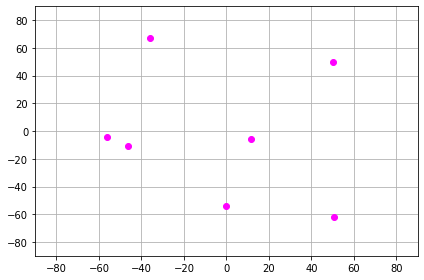

In [89]:
def main(nLandmarks=7, env_size=140):
    # MATPLOTLIB
    fig, ax = plt.subplots() 
    plt.xlim([-90, 90])
    plt.ylim([-90, 90])
    plt.grid()
    plt.ion()
    plt.tight_layout()

    fig.canvas.draw()
    
    # VARIABLES
    num_landmarks = 7 # number of landmarks in the environment
    env_size = 140 # A square environment with x=[-env_size/2,env_size/2] and y=[-env_size/2,env_size/2]
       
    # MAP CREATION AND VISUALIZATION
    w_map = env_size*scipy.rand(2, num_landmarks) - env_size/2 # randomly place the landmarks in the map
    ax.plot(w_map[0, :], w_map[1, :], 'o', color='magenta', label="Landmarks")
    
    # ROBOT POSE AND SENSOR INITIALIZATION 
    desv_d = 0.5 # standard deviation (noise) of the range measurement
    cov = np.diag([25, 30, np.pi*180])**2 # covariance of the motion (odometry)
    xStart = np.vstack(plt.ginput(1)).T # get the robot starting point from the user
    robot_pose=np.vstack([xStart, 0]) # robot_pose
    
    R1 = Robot(robot_pose, cov, desv_d)
    R1.plot(fig, ax)

    # MAIN
    z = distance(R1.true_pose, w_map, cov_d=R1.var_d) # take (noisy) measurements to the landmarks
    LeastSquaresLocalization(R1, w_map, z) # LS Positioning!
    
    # PLOTTING RESULTS
    plt.legend()
    fig.canvas.draw()

# RUN    
main()

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Having completed this notebook above, you will be able to **answer the following questions**:

- What are the dimensions of the error residuals? Does them depend on the number of observations? 

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Las dimensiones son 1x1, lo que obtenemos es un escalar. No porque se obtiene de multiplicar la matriz de errores traspuesta por la matriz de errores, como la matriz de errores tiene mx1 componentes, siendo m el número de observaciones, entonces lo que hacemos es multiplicar una matriz de dimensiones 1xm por una matriz de dimensión mx1, como resultado obtenemos un escalar. </i></p>

- Why is Weighted LS obtaining better results than LS?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Porque le estamos dando a cada observación un peso, de manera que las observaciones que tengan mayor probabiliad de error (en este caso las que se hacen a una mayor distancia) son las que tienen menos peso a la hora de calcular la pose del robot, y las observaciones más fiables son las que cobran mayor importancia.</i></p>

- Which is the minimum number of landmarks needed for localizing the robot? Why?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Necesitamos tantos landmarks como componentes tenga la pose del robot porque de esa manera la ecuación tiene una solución ya que tenemos más observaciones (m) que incógnitas (n). Si m es menor que n existen infinitas soluciones para el sistema de ecuaciones y, por lo tanto, infinitas soluciones para la pose del robot.</i></p>

- Play with different “qualities” of the range sensor. Could you find a value for its variance so the LS method fails?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

- Play also with different values for the odometry uncertainty. What does this affect? 

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>